## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [2]:
def loadData(ns = 50, N_train = 70, N_test = 29, cov_len = 126):
    """
    Load the covariance matrices
    """

    name_root="samples2/ns50/xiell_cov_noisy_ns{}_".format(ns)
    train_data = np.zeros((N_train, cov_len, cov_len))
    test_data = np.zeros((N_test, cov_len, cov_len))
    for i in range(N_train):
        train_data[i] = np.loadtxt(name_root+"{:04d}.dat".format(i+1))
    for i in range(N_test):
        test_data[i] = np.loadtxt(name_root+"{:04d}.dat".format(N_train+i+1))
    
    return train_data, test_data
    

In [23]:
def preprocess_cov(array, theory_cov):
    cov_len = len(theory_cov)
    for i in range(cov_len):
        for j in range(cov_len):
            array[:, i, j] /= np.sqrt(theory_cov[i, i] * theory_cov[j, j])
    array = np.reshape(array, (len(array), cov_len, cov_len))
    return array

In [24]:
def preprocess_alpha(covs, theory_cov):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """
    covs_norm = []
    for cov in covs:
      theory_diag = np.diagonal(theory_cov)
      cov_ii = cov/np.sqrt(theory_diag)
      cov_jj = np.transpose(cov_ii)/np.sqrt(theory_diag)
      covs_norm.append(np.transpose(cov_jj))

    
    return np.array(covs_norm)

In [25]:
def preprocess_theory(theory_cov, N = 70):
    cov_len = len(theory_cov)
    array = np.zeros((N, cov_len, cov_len))
    for i in range(cov_len):
        for j in range(cov_len):
            array[:, i, j] = theory_cov[i, j] / np.sqrt(theory_cov[i, i] * theory_cov[j, j])
    array = np.reshape(array, (len(array), cov_len, cov_len, 1))
    return array

## Prepare the data

In [32]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
_train_data, _test_data = loadData(N_train=70, N_test=29)
theory_cov = np.loadtxt("samples2/xi_new_boss_zs_z0p61_lin_ximulti_covar.dat")

# Normalize and reshape the data
train_data = preprocess_cov(_train_data, theory_cov=theory_cov)
# train_data_alpha = preprocess_alpha(_train_data, theory_cov=theory_cov)

test_data = preprocess_cov(_test_data, theory_cov=theory_cov)
# test_data_alpha = preprocess_alpha(_test_data, theory_cov=theory_cov)
target_data = preprocess_theory(theory_cov)

# Display the train data and a version of it with added noise
# display(train_data, train_data)

cov_len = len(theory_cov)

## Build the autoencoder

In [42]:
input = layers.Input(shape=(cov_len, cov_len, 1))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 126, 126, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 126, 126, 64)      640       
                                                                 
 conv2d_19 (Conv2D)          (None, 126, 126, 32)      18464     
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 126, 126, 32)     9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 126, 126, 64)     18496     
 Transpose)                                                      
                                                                 
 conv2d_20 (Conv2D)          (None, 126, 126, 1)       577 

## Training and testing

In [53]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=1,
    shuffle=True,
    validation_data=(test_data, test_data),
)
predictions = autoencoder.predict(test_data)
# display(test_data, predictions, n=2)
plt.imshow(test_data[0].reshape(cov_len, cov_len))


Epoch 1/50
70/70 [==============================] - 4s 46ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 2/50
70/70 [==============================] - 3s 37ms/step - loss: 0.0134 - val_loss: 0.0138
Epoch 3/50
70/70 [==============================] - 3s 36ms/step - loss: 0.0133 - val_loss: 0.0136
Epoch 4/50
70/70 [==============================] - 3s 36ms/step - loss: 0.0132 - val_loss: 0.0136
Epoch 5/50
70/70 [==============================] - 3s 36ms/step - loss: 0.0132 - val_loss: 0.0136
Epoch 6/50
70/70 [==============================] - 2s 36ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 7/50
70/70 [==============================] - 2s 36ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 8/50
70/70 [==============================] - 2s 36ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 9/50
70/70 [==============================] - 3s 37ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 10/50
70/70 [==============================] - 3s 36ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 11/

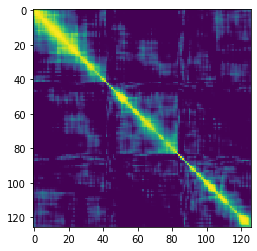

In [44]:
plt.imshow(predictions[0].reshape(cov_len, cov_len))

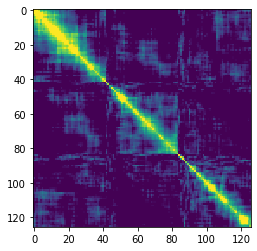

In [39]:
plt.imshow(predictions[0].reshape(cov_len, cov_len))


In [46]:
autoencoder.fit(
    x=train_data,
    y=target_data,
    epochs=50,
    batch_size=10,
    shuffle=True,
    validation_data=(test_data, target_data[:29]),
)

Epoch 1/50
7/7 [==============================] - 1s 158ms/step - loss: 0.0113 - val_loss: 0.0105
Epoch 2/50
7/7 [==============================] - 1s 113ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 3/50
7/7 [==============================] - 1s 115ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 4/50
7/7 [==============================] - 1s 113ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 5/50
7/7 [==============================] - 1s 111ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/50
7/7 [==============================] - 1s 110ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 7/50
7/7 [==============================] - 1s 112ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 8/50
7/7 [==============================] - 1s 109ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 9/50
7/7 [==============================] - 1s 110ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 10/50
7/7 [==============================] - 1s 109ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 11/50
7/7 [==

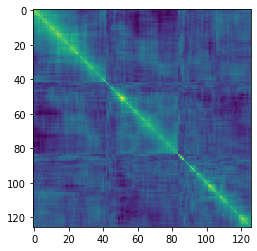

In [52]:
plt.imshow(test_data[0].reshape(cov_len, cov_len))

1/1 [==============================] - 0s 109ms/step


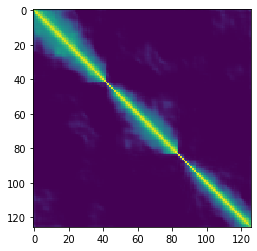

In [50]:
predictions = autoencoder.predict(test_data)
plt.imshow(predictions[0].reshape(cov_len, cov_len))


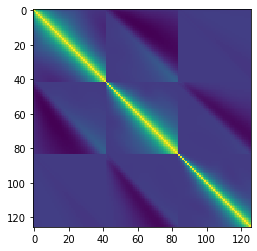

In [51]:
plt.imshow(target_data[0].reshape(cov_len, cov_len))